In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10838982664245741479
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7699151668
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18249764969433766745
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [4]:
data = pd.read_pickle("../../Data/Guitar/guitar-string-data-500.pkl")

In [5]:
data["String"] = data["String"].values.astype("int") - 1

In [6]:
data["String"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [3]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.sample(round(0.8*df.shape[0])), target_column)
    df = df.drop(X_train.index)
    X_val, y_val = create_xy(df.sample(round(0.5*df.shape[0])), target_column)
    df = df.drop(X_val.index)
    X_test, y_test = create_xy(df, target_column)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "String")

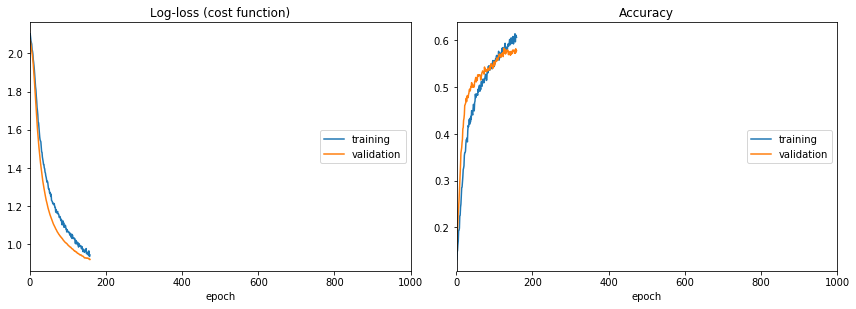

Log-loss (cost function):
training   (min:    0.937, max:    2.102, cur:    0.945)
validation (min:    0.921, max:    2.070, cur:    0.921)

Accuracy:
training   (min:    0.131, max:    0.614, cur:    0.607)
validation (min:    0.150, max:    0.584, cur:    0.578)


KeyboardInterrupt: 

In [23]:
inputs = Input(shape=(500,))
hidden1 = Dense(128, kernel_regularizer=l2(0.0), activation="relu")(inputs)
hidden1_drop = Dropout(0.6)(hidden1)
hidden2 = Dense(64, kernel_regularizer=l2(0.0), activation="relu")(hidden1_drop)
hidden2_drop = Dropout(0.6)(hidden2)
preds = Dense(8, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=1000, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

## Spectral

In [4]:
data = pd.read_pickle("../../Data/Guitar/guitar-spectral-string-data-500.pkl")

In [5]:
data["String"] = data["String"].values.astype("int") - 1

In [7]:
data["String"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "String")

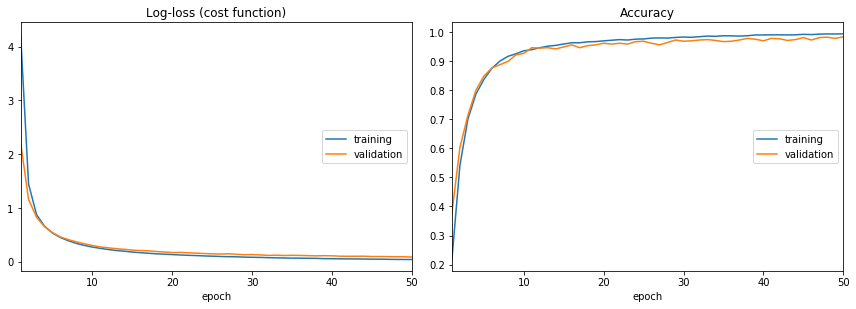

Log-loss (cost function):
training   (min:    0.037, max:    4.242, cur:    0.037)
validation (min:    0.083, max:    2.223, cur:    0.083)

Accuracy:
training   (min:    0.218, max:    0.994, cur:    0.994)
validation (min:    0.377, max:    0.983, cur:    0.983)
Train score: 0.03339344828749783
Train accuracy: 0.9949477351916376
Validation score: 0.0828692355221734
Validation accuracy: 0.9832869080779945


In [11]:
inputs = Input(shape=(500,))
hidden1 = Dense(256, kernel_regularizer=l1(0.000))(inputs)
#hidden1_drop = Dropout(0.1)(hidden1)
hidden2 = Dense(128, kernel_regularizer=l2(0.00), activation="relu")(hidden1)
hidden2_drop = Dropout(0.0)(hidden2)
preds = Dense(61, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=50, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

In [12]:
model.save_weights('Guitar_string_NN_weights.h5')

In [13]:
with open('Guitar_string_NN_architecture.json', 'w') as f:
    f.write(model.to_json())